In [2]:
"""\
# Copyright (C) 2023 Jesús Bautista Villar <jesbauti20@gmail.com>
"""
!python3 --version

Python 3.10.12


In [2]:
import os
import pandas as pd
import numpy as np

# Graphic tool
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams["mathtext.fontset"] = "cm"

font = {"size" : 12}

matplotlib.rc("font", **font)

# Data directory
DATA_PATH = os.path.join("data")

In [3]:
def load_data(filename, t0, tf=None):
    """
    Load Paparazzi .csv data files
    """
    data = pd.read_csv(os.path.join(DATA_PATH, filename), sep="\t")
    if tf is None:
        data = data.loc[(data["Time"] >= t0)]
    else:
        data = data.loc[(data["Time"] >= t0) & (data["Time"] <= tf)]
    return data

def vector2d(
        ax, 
        P0, Pf, 
        c="k", ls="-", s=1, lw=0.7, hw=0.1, hl=0.2, alpha=1, zorder=1):
    """
    Function to easy plot a 2D vector
    """
    quiv = ax.arrow(
        P0[0],
        P0[1],
        s * Pf[0],
        s * Pf[1],
        lw=lw,
        color=c,
        ls=ls,
        head_width=hw,
        head_length=hl,
        length_includes_head=True,
        alpha=alpha,
        zorder=zorder,
    )
    return quiv

## Read the logs

In [94]:
# Loading data
t0, tf = 0, None
filename = "24_09_11__10_04_38.csv"
filename = "24_09_11__10_48_44.csv"

data = load_data(filename, t0, tf)

# Procressing the data
data_time = np.array(data["Time"].to_list())
data_x = np.array(data["NAVIGATION:pos_x"].to_list())
data_y = np.array(data["NAVIGATION:pos_y"].to_list())
data_phi = np.array(data["GVF:phi"].to_list())
data_omega_d = np.array(data["GVF:omega_d"].to_list())
data_omega = np.array(data["GVF:omega"].to_list())
data_n_norm = np.array(data["GVF:n_norm"].to_list())
data_t_norm = np.array(data["GVF:t_norm"].to_list())
data_ke = np.array(data["GVF:ke"].to_list())

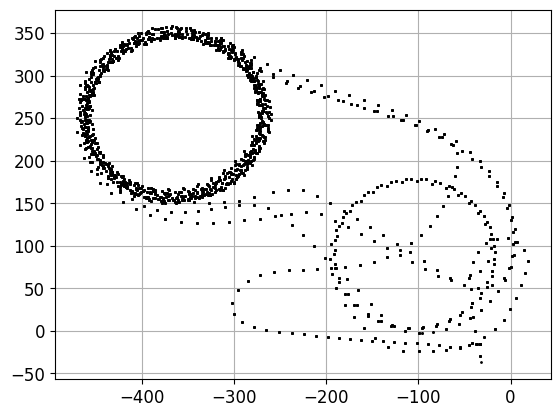

In [95]:
plt.plot(data_x, data_y, ".k", markersize=2)
plt.grid(True)

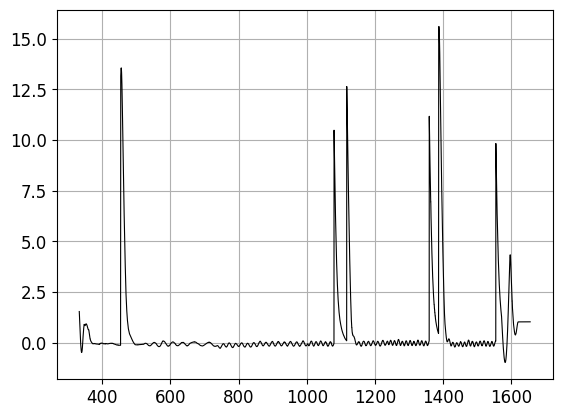

In [96]:
plt.plot(data_time, data_phi, "-k", markersize=2, lw=0.8)
plt.grid(True)

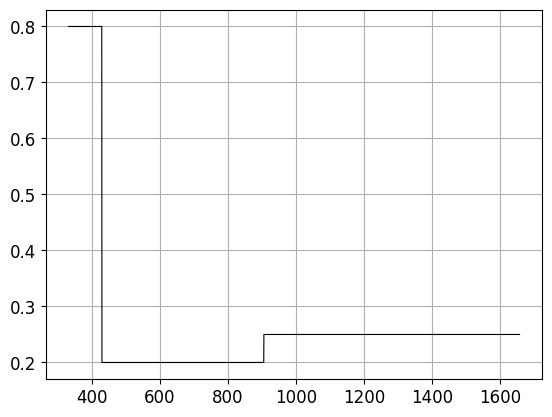

In [97]:
plt.plot(data_time, data_ke, "-k", markersize=2, lw=0.8)
plt.grid(True)

## Generate the article plots

### Experiment 1

In [70]:
class GVF_IK_exp1:
    def __init__(self, data, ke, t0_cond):
        # Procressing the data
        self.data_time = np.array(data["Time"].to_list())
        self.data_x = np.array(data["NAVIGATION:pos_x"].to_list())
        self.data_y = np.array(data["NAVIGATION:pos_y"].to_list())
        self.data_phi = np.array(data["GVF:phi"].to_list())
        self.data_omega_d = np.array(data["GVF:omega_d"].to_list())
        self.data_omega = np.array(data["GVF:omega"].to_list())
        self.data_n_norm = np.array(data["GVF:n_norm"].to_list())
        self.data_t_norm = np.array(data["GVF:t_norm"].to_list())

        self.ke = ke

        self.data_time = self.data_time - self.data_time[0]

        self.t0 = t0_cond
        self.phi0 = self.data_phi[self.data_time < self.t0][-1]

    def plot(
            self, 
            dpi=100, 
            figsize=(14,8), 
            xlim=None, 
            ylim=None,
            plot_xy=False,
            ):
        fig = plt.figure(figsize=figsize, dpi=dpi)
        grid = plt.GridSpec(3, 4, hspace=0.2, wspace=0.2)
        ax = fig.add_subplot(grid[:, 0:2], xticklabels=[], yticklabels=[])
        axr1 = fig.add_subplot(grid[0, 2:4])
        axr2 = fig.add_subplot(grid[1, 2:4])
        axr3 = fig.add_subplot(grid[2, 2:4])

        # Axis configuration
        if xlim is not None:
            ax.set_xlim(xlim)
        if ylim is not None:
            ax.set_ylim(ylim)

        ax.set_xlabel("$X$")
        ax.set_ylabel("$Y$")
        ax.set_aspect("equal")

        # Right axis configuration
        axr1.set_ylabel(r"$\phi$")
        axr1.yaxis.set_major_formatter(plt.FormatStrFormatter("%.2f"))
        axr1.yaxis.tick_right()
        axr1.grid(True)
        axr2.set_ylabel(r"[rad/s]")
        axr2.yaxis.set_major_formatter(plt.FormatStrFormatter("%.2f"))
        axr2.yaxis.tick_right()
        axr2.grid(True)
        axr3.set_ylabel(r"[m/s]")
        axr3.set_xlabel(r"$t$ [s]")
        axr3.yaxis.set_major_formatter(plt.FormatStrFormatter("%.2f"))
        axr3.yaxis.tick_right()
        axr3.grid(True)

        # Plot: 2D X-Y
        if plot_xy:
            ax.plot(self.data_x, self.data_y)
        else:
            ax.imshow(plt.imread(os.path.join(DATA_PATH, "exp1.png")))
        
        # Plot: phi
        axr1.axhline(0, color="k", ls="-", lw=1)
        axr1.axvline(self.t0, color="k", ls="--", lw=0.8)
        # axr1.axhline(0.1, color="k", ls="--", lw=0.8)
        # axr1.axhline(-0.1, color="k", ls="--", lw=0.8)

        exp_time = self.data_time[self.data_time > self.t0]
        exp_data = self.phi0*np.exp(-self.ke*(exp_time - self.t0))
        axr1.plot(self.data_time, self.data_phi, lw=1.5)
        axr1.plot(exp_time, exp_data, "--r", lw=1.5, label=r"$\dot{\phi}(t) = - k_e \phi(t)$")
        axr1.legend(fancybox=True, prop={"size": 12}, ncols=2)


        # Plot: omega plot
        axr2.axhline(0, color="k", ls="-", lw=1)
        axr2.axvline(self.t0, color="k", ls="--", lw=0.8)

        axr2.plot(self.data_time, self.data_omega_d, "r", lw=1.5, label=r"$\omega_d(t)$")
        axr2.plot(self.data_time, self.data_omega, lw=1.5, label=r"$\omega(t)$")
        axr2.legend(fancybox=True, prop={"size": 12}, ncols=2)

        # Plot: tangent and normal norms of pd
        axr3.axhline(0, color="k", ls="-", lw=1)
        axr3.axvline(self.t0, color="k", ls="--", lw=0.8)

        axr3.plot(self.data_time, self.data_t_norm, "r", lw=1.5, label=r"$||v_t(t)||$")
        axr3.plot(self.data_time, self.data_n_norm, lw=1.5, label=r"$||v_c(t)||$")
        axr3.legend(fancybox=True, prop={"size": 12}, ncols=2)
        
        # -> Show the plot <-
        ax.grid(True)
        plt.show()

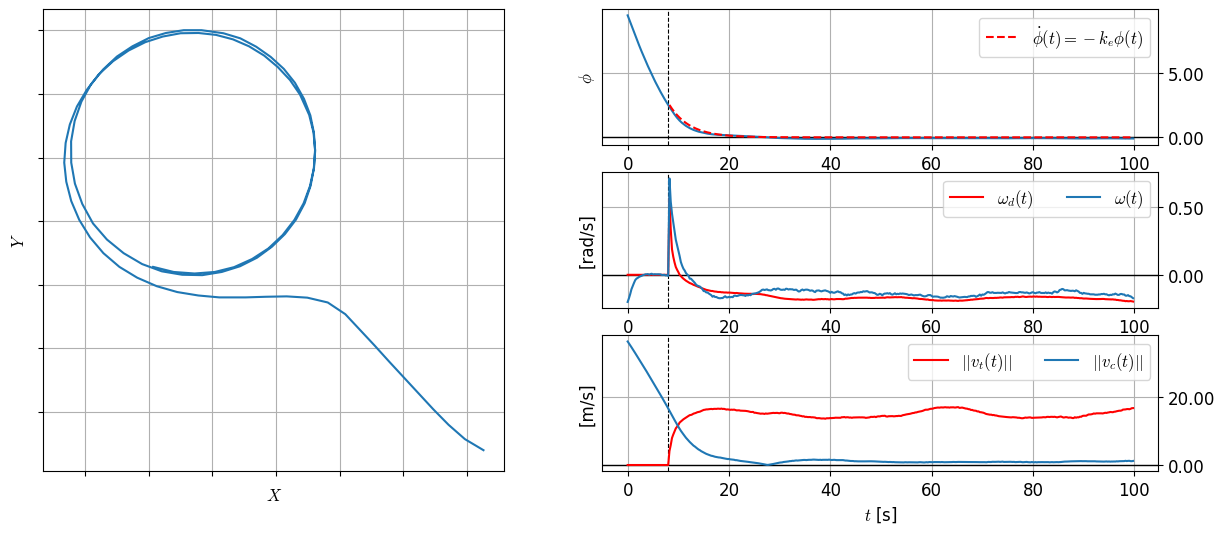

In [92]:
# Loading data
t0, tf, t0_cond, ke = 1600+88, 1600+88+100, 8, 0.25 # kn=0.6
# t0, tf, t0_cond, ke = 1600+280, 1600+280+100, 9, 0.20 # kn=0.6 -> 0.8
# t0, tf, t0_cond, ke = 1600+480, 1600+480+70, 0.01, 0.15 # kn=0.8

filename = "24_09_11__10_04_38.csv"

data = load_data(filename, t0, tf)

exp = GVF_IK_exp1(data, ke=ke, t0_cond=t0_cond)
exp.plot(dpi=100, figsize=(15,6), plot_xy=True)

### Experiment 2

In [183]:
class GVF_IK_exp2:
    def __init__(self, data, A, omega, t0_sin):
        # Procressing the data
        self.data_time = np.array(data["Time"].to_list())
        self.data_x = np.array(data["NAVIGATION:pos_x"].to_list())
        self.data_y = np.array(data["NAVIGATION:pos_y"].to_list())
        self.data_phi = np.array(data["GVF:phi"].to_list())
        self.data_omega_d = np.array(data["GVF:omega_d"].to_list())
        self.data_omega = np.array(data["GVF:omega"].to_list())
        self.data_n_norm = np.array(data["GVF:n_norm"].to_list())
        self.data_t_norm = np.array(data["GVF:t_norm"].to_list())

        self.A = A
        self.omega = omega

        self.data_time = self.data_time - self.data_time[0]
        self.t0_sin = t0_sin

    def plot(
            self, 
            dpi=100, 
            figsize=(14,8), 
            xlim=None, 
            ylim=None,
            plot_xy=False,
            ):
        fig = plt.figure(figsize=figsize, dpi=dpi)
        grid = plt.GridSpec(3, 4, hspace=0.2, wspace=0.2)
        ax = fig.add_subplot(grid[:, 0:2], xticklabels=[], yticklabels=[])
        axr1 = fig.add_subplot(grid[0, 2:4])
        axr2 = fig.add_subplot(grid[1, 2:4])
        axr3 = fig.add_subplot(grid[2, 2:4])

        # Axis configuration
        if xlim is not None:
            ax.set_xlim(xlim)
        if ylim is not None:
            ax.set_ylim(ylim)

        ax.set_xlabel("$X$")
        ax.set_ylabel("$Y$")
        ax.set_aspect("equal")

        # Right axis configuration
        axr1.set_ylabel(r"$\phi$")
        axr1.yaxis.set_major_formatter(plt.FormatStrFormatter("%.2f"))
        axr1.yaxis.tick_right()
        axr1.grid(True)
        axr2.set_ylabel(r"[rad/s]")
        axr2.yaxis.set_major_formatter(plt.FormatStrFormatter("%.2f"))
        axr2.yaxis.tick_right()
        axr2.grid(True)
        axr3.set_ylabel(r"[m/s]")
        axr3.set_xlabel(r"$t$ [s]")
        axr3.yaxis.set_major_formatter(plt.FormatStrFormatter("%.2f"))
        axr3.yaxis.tick_right()
        axr3.grid(True)

        # Plot: 2D X-Y
        if plot_xy:
            ax.plot(self.data_x, self.data_y)
        else:
            ax.imshow(plt.imread(os.path.join(DATA_PATH, "exp2.png")))
        
        # Plot: phi
        axr1.axhline(0, color="k", ls="-", lw=1)
        axr1.axhline(self.A, color="k", ls="--", lw=0.8)
        axr1.axhline(-self.A, color="k", ls="--", lw=0.8)

        sin_time = self.data_time
        sin_data = self.A*np.sin(self.omega*(sin_time + self.t0_sin))
        axr1.plot(self.data_time, self.data_phi, lw=1.5)
        axr1.plot(sin_time, sin_data, "--r", lw=1.5, label=r"$A\,\sin(\omega t)$")
        axr1.legend(fancybox=True, prop={"size": 12}, ncols=2)


        # Plot: omega plot
        axr2.axhline(0, color="k", ls="-", lw=1)

        axr2.plot(self.data_time, self.data_omega_d, "r", lw=1.5, label=r"$\omega_d(t)$")
        axr2.plot(self.data_time, self.data_omega, lw=1.5, label=r"$\omega(t)$")
        axr2.legend(fancybox=True, prop={"size": 12}, ncols=2)

        # Plot: tangent and normal norms of pd
        axr3.axhline(0, color="k", ls="-", lw=1)

        axr3.plot(self.data_time, self.data_t_norm, "r", lw=1.5, label=r"$||v_t(t)||$")
        axr3.plot(self.data_time, self.data_n_norm, lw=1.5, label=r"$||v_c(t)||$")
        axr3.legend(fancybox=True, prop={"size": 12}, ncols=2)
        
        # -> Show the plot <-
        ax.grid(True)
        plt.show()

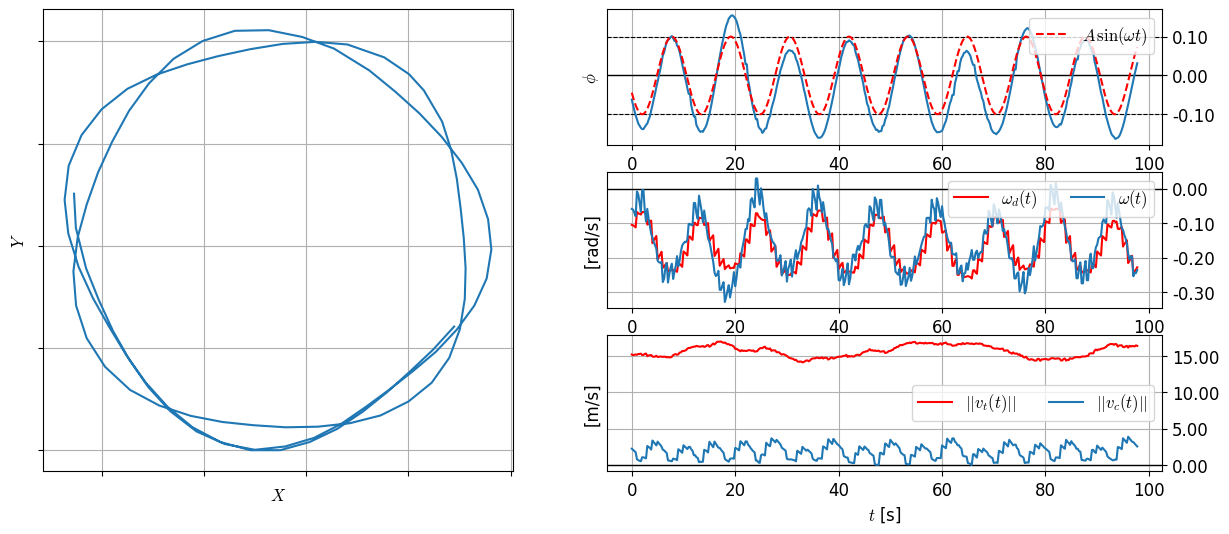

In [184]:
# Loading data
t0, tf, omega = 750, 1060, 0.55  # kn=0.8, ke=0.25
t0, tf, t0_sin, omega = 1150, 1200, 0.25, 0.45  # kn=0.8, ke=0.25
t0, tf, t0_sin, omega = 1250, 1348, 6.55, 0.55  # kn=0.8, ke=0.25

filename = "24_09_11__10_48_44.csv"

data = load_data(filename, t0, tf)

exp = GVF_IK_exp2(data, A=0.1, omega=omega, t0_sin=t0_sin)
exp.plot(dpi=100, figsize=(15,6), plot_xy=True)

### Experiment 3

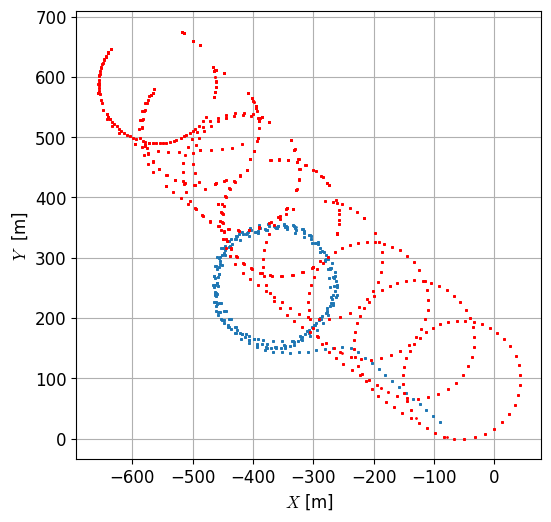

In [99]:
# Loading data
t0, tf = 180, None
t0_old, tf_old = 800, 1400

filename = "24_09_09__12_56_10.csv"
filename_old = "24_08_08__08_26_39.csv"

data = load_data(filename, t0, tf)
data_old = load_data(filename_old, t0_old, tf_old)

# Procressing the data
data_x = np.array(data["NAVIGATION:pos_x"].to_list())
data_y = np.array(data["NAVIGATION:pos_y"].to_list())

data_x_old = np.array(data_old["NAVIGATION:pos_x"].to_list())
data_y_old = np.array(data_old["NAVIGATION:pos_y"].to_list())

# Plot
fig = plt.figure(figsize=(6,6))
ax = fig.subplots()

ax.set_xlabel("$X$ [m]")
ax.set_ylabel("$Y$  [m]")
ax.set_aspect("equal")

ax.plot(data_x, data_y, ".", markersize=2)
ax.plot(data_x_old, data_y_old, ".r", markersize=2)
ax.grid(True)

plt.show()